# 0 IMPORTS

In [ ]:
import pandas as pd
import numpy as np
import inflection
import math
import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import random
import pickle

from scipy import stats as ss
from matplotlib.gridspec import GridSpec
from datetime import timedelta
from boruta import BorutaPy
from IPython.display import Image

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error

import os
os.chdir('..')
warnings.filterwarnings( 'ignore' )

## 0.1 Helper Functions

In [2]:
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list  = []
    mape_list = []
    rmse_list = []
    
    for k in reversed(range(1, kfold + 1)):
        
        if verbose:
            print('\nKFold Number: {}'.format(k))
        
        # Definindo janela de validação (6 semanas por fold)
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date   = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)
        
        # Separando treino e validação (sem leakage!)
        training   = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & 
                                (x_training['date'] <= validation_end_date)]
        
        # Preparando features e target
        xtraining    = training.drop(['date', 'sales'], axis=1)
        ytraining    = training['sales']
        
        xvalidation  = validation.drop(['date', 'sales'], axis=1)
        yvalidation  = validation['sales']
        
        # Treinando o modelo
        m = model.fit(xtraining, ytraining)
        
        # Fazendo predição
        yhat = m.predict(xvalidation)
        
        # Calculando métricas (com expm1 porque target está em log)
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        # Armazenando resultados de cada fold
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
    
    # Retornando tabela com média ± desvio padrão
    return pd.DataFrame({
        'Model Name': model_name,
        'MAE CV':  np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
        'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
        'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)
    }, index=[0])


def mean_percentage_error(y, yhat):
    """MPE - Mede viés (sinal positivo/negativo)"""
    return np.mean((y - yhat) / y)


def mean_absolute_percentage_error(y, yhat):
    """MAPE - Erro percentual absoluto médio (em decimal ou %)"""
    return np.mean(np.abs((y - yhat) / y))


def ml_error(model_name, y_true, y_pred):
    """
    Retorna tabela com métricas de performance do modelo
    """
    mae  = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    return pd.DataFrame({
        'Model Name': model_name,
        'MAE':  mae,
        'MAPE': mape,  
        'RMSE': rmse
    }, index=[0])


def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


def vscode_settings():
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)

    sns.set()


In [3]:
vscode_settings()

## 0.2 Load data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1 DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [7]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Confirm NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [10]:
#competition_distance(if NA is listed, it means the competitor is very far from my store or someone forgot to register. Therefore, including the maximum value signifies this.)
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month (include the month of the sale, as a competitor's store can interfere with sales growth)
df1['competition_open_since_month'] = (df1.apply(lambda x: x['date'].month 
                                                 if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1))
#competition_open_since_year (include the year of the sale, as a competitor's store can interfere with sales growth)
df1['competition_open_since_year'] = (df1.apply(lambda x: x['date'].year 
                                                 if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1))              
#promo2_since_week (this means that the store didn't participate in promotion 2; there was no continuity from promotion 1 to promotion 2)
df1['promo2_since_week'] = (df1.apply(lambda x: x['date'].week 
                                                 if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1))       
#promo2_since_year (this means that the store didn't participate in promotion 2; there was no continuity from promotion 1 to promotion 2)
df1['promo2_since_year'] = (df1.apply(lambda x: x['date'].year 
                                                 if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1))         
#promo_interval
month_map = {
                1: 'Jan',
                2: 'Feb',
                3: 'Mar',
                4: 'Apr',
                5: 'May',
                6: 'Jun',
                7: 'Jul',
                8: 'Aug',
                9: 'Sep',
                10: 'Oct',
                11: 'Nov',
                12: 'Dec',
            }
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = (df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval']
                                                      .split(',') else 0, axis=1))

In [11]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [12]:
df1.sample(5).T

,223866,919242,211932,147841,131614
store,867,153,83,662,45
day_of_week,1,5,4,6,6
date,2015-01-12 00:00:00,2013-03-29 00:00:00,2015-01-22 00:00:00,2015-03-21 00:00:00,2015-04-04 00:00:00
sales,6410,0,2926,6980,7943
customers,513,0,287,663,642
open,1,0,1,1,1
promo,1,1,0,0,0
state_holiday,0,b,0,0,0
school_holiday,0,1,0,0,0
store_type,d,a,a,d,d


## 1.6 Change Types

In [13]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [14]:
df1[['competition_open_since_month', 'competition_open_since_year', 'promo2_since_week', 'promo2_since_year']] = (df1
                                                                                                                  [['competition_open_since_month', 'competition_open_since_year', 'promo2_since_week', 'promo2_since_year']].astype(int))

## 1.7 Descriptive Statistical

In [15]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical attributes

In [16]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis())).T

# concatenate

m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


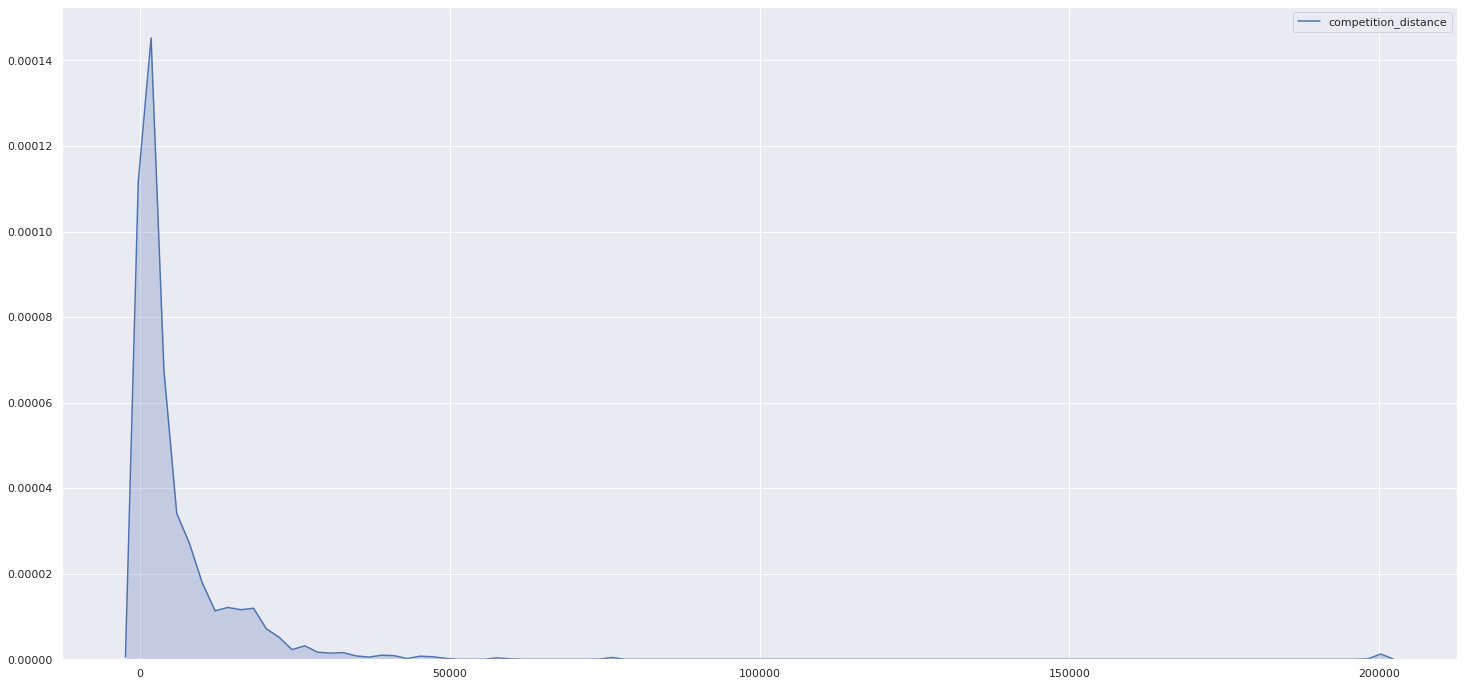

In [17]:
sns.kdeplot(df1['competition_distance'], shade=True)

### 1.7.1 Categorical attributes

In [18]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

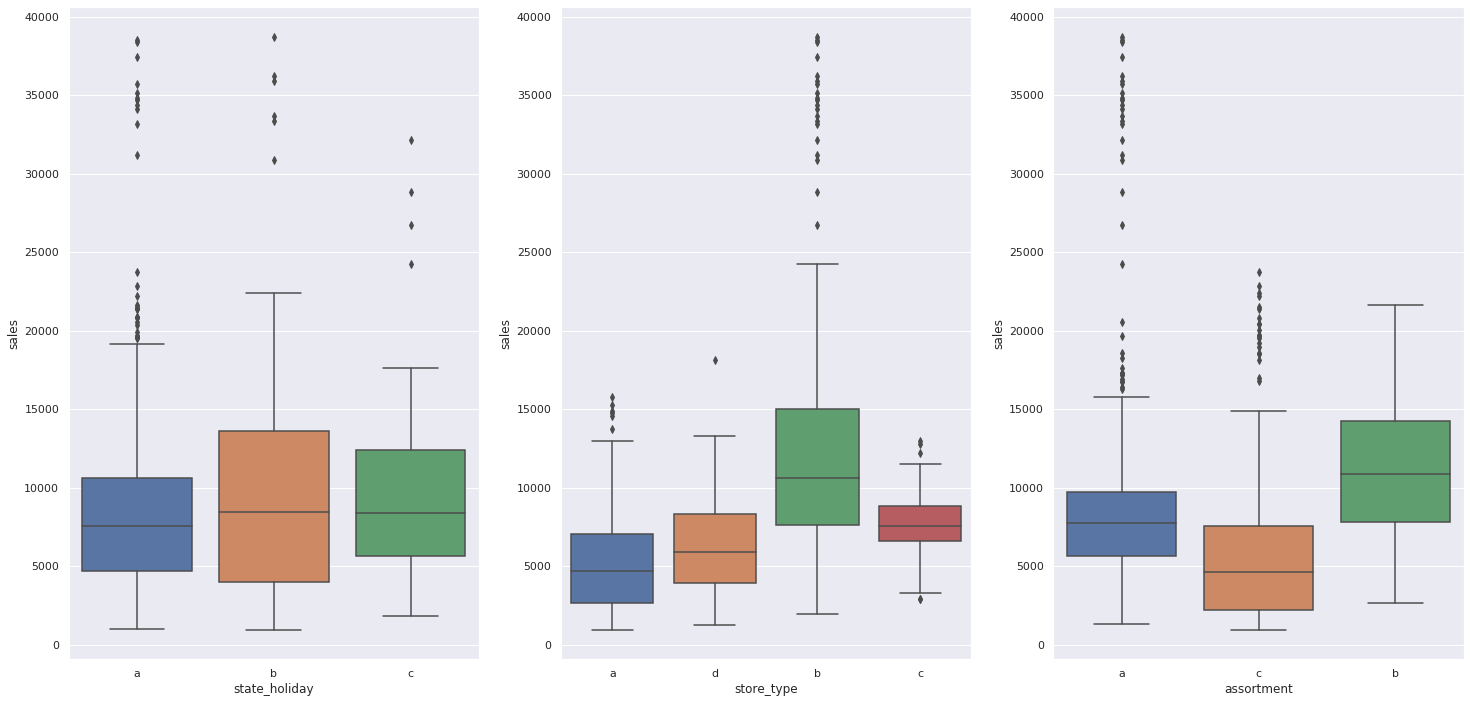

In [19]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0 FEATURE ENGINEERING

In [20]:
df2 = df1.copy()

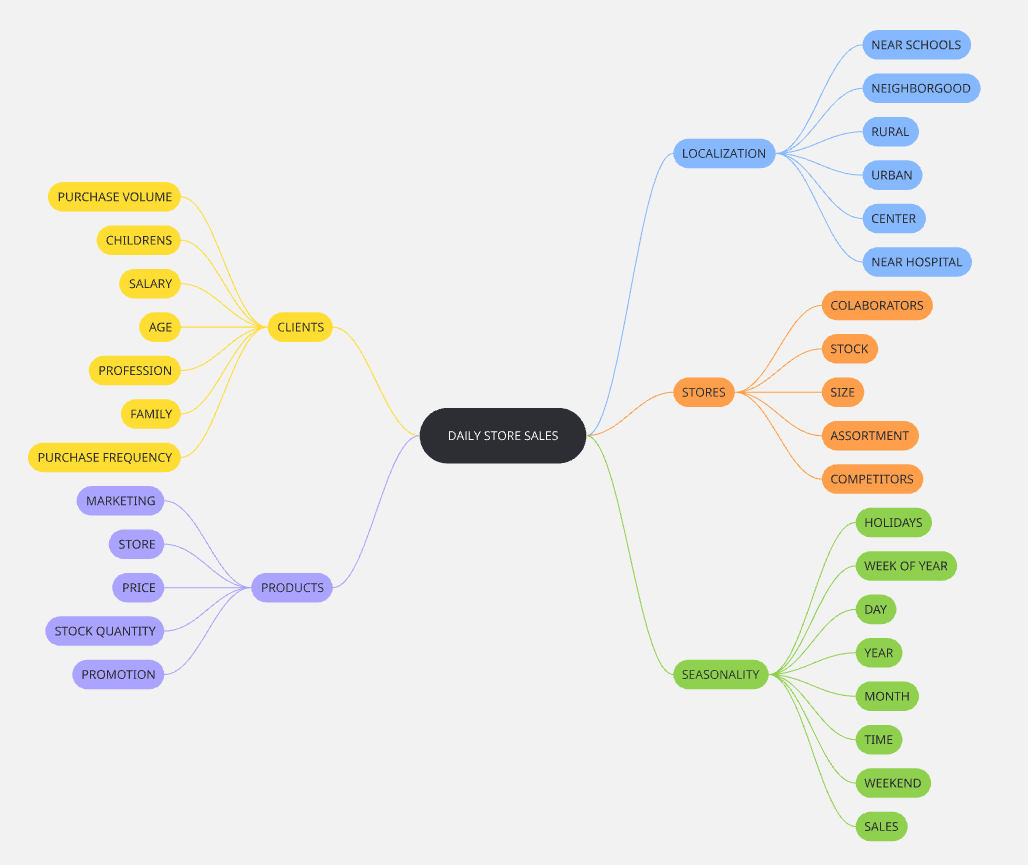

In [21]:
Image('img/mind_map.png')

## 2.1 Creation of Hypotheses

### 2.1.1 Hypotheeses Store

**1 -** Lojas com numero maior de funcionarios deveriam vender mais.

**2 -** Lojas com maior capacidade de estoque deveriam vender mais.

**3 -** Lojas com maior porte deveriam vender mais.

**4 -** Lojas com maior variedade deveriam vender mais.

**5 -** Lojas com competidores mais proximos deveriam vender menos.

**6 -** Lojas com competidores a mais tempo deveriam vender mais.

### 2.1.2 Hypotheeses Product

**1 -** Lojas que investem mais em Marketing deveriam vender mais.

**2 -** Lojas com maior exposicao de produtos deveriam vender mais.

**3 -** Lojas com produtos com preco menor deveriam vender mais.

**4 -** Lojas com promocoes mais agressivas deveriam vender mais.

**5 -** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**6 -** Lojas com mais dias de promocao deveriam vender mais.

**7 -** Lojas com mais promocoes consecutivas deveriam vender mais.

### 2.1.2 Hypotheeses Seasonality

**1 -** Lojas abertas durante o feriado de natal deveriam vender mais.

**2 -** Lojas deveriam vender mais ao longo dos anos.

**3 -** Lojas deveriam vender mais no segundo semestre do ano

**4 -** Lojas deveriam vender mais depois do dia 10 de cada mes.

**5 -** Lojas deveriam vender menos aos finais de semana.

**6 -** Lojas deveriam vender menos durante os feriados escolares.

## 2.2 Final List - Hypotheses

**1 -** Lojas com maior variedade deveriam vender mais.

**2 -** Lojas com competidores mais proximos deveriam vender menos.

**3 -** Lojas com competidores a mais tempo deveriam vender mais.

-----------

**4 -** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**5 -** Lojas com mais dias de promocao deveriam vender mais.

**6 -** Lojas com mais promocoes consecutivas deveriam vender mais.

-----------

**7 -** Lojas abertas durante o feriado de natal deveriam vender mais.

**8 -** Lojas deveriam vender mais ao longo dos anos.

**9 -** Lojas deveriam vender mais no segundo semestre do ano

**10 -** Lojas deveriam vender mais depois do dia 10 de cada mes.

**11 -** Lojas deveriam vender menos aos finais de semana.

**12 -** Lojas deveriam vender menos durante os feriados escolares.


## 2.3 Feature Engineering

In [22]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear
# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)
# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - timedelta(days = 7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
# state holiday
df2['state_holiday'] = (df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' 
                                                   if x == 'b' else 'christmas' if x == 'c' else 'regular_day'))


In [23]:
df2.sample(5).T

,24395,328942,817428,262463,814719
store,981,1113,919,1001,440
day_of_week,5,3,6,4,1
date,2015-07-10 00:00:00,2014-09-24 00:00:00,2013-06-29 00:00:00,2014-12-04 00:00:00,2013-07-01 00:00:00
sales,6728,4756,3338,7648,7808
customers,732,587,399,738,794
open,1,1,1,1,1
promo,0,0,0,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,0,0,0,0,0
store_type,d,a,a,c,d


# 3.0 VARIABLE FILTERING

In [24]:
df3 = df2.copy()

In [25]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Line Filtering

In [26]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Columns Selection

In [27]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [28]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 EDA

In [29]:
df4 = df3.copy()

**1 -** Lojas com maior sortimento deveriam vender mais.

**2 -** Lojas com competidores mais proximos deveriam vender menos.

**3 -** Lojas com competidores a mais tempo deveriam vender mais.

-----------

**4 -** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**5 -** Lojas com mais dias de promocao deveriam vender mais.

**6 -** Lojas com mais promocoes consecutivas deveriam vender mais.

-----------

**7 -** Lojas abertas durante o feriado de natal deveriam vender mais.

**8 -** Lojas deveriam vender mais ao longo dos anos.

**9 -** Lojas deveriam vender mais no segundo semestre do ano

**10 -** Lojas deveriam vender mais depois do dia 10 de cada mes.

**11 -** Lojas deveriam vender menos aos finais de semana.

**12 -** Lojas deveriam vender menos durante os feriados escolares.


## 4.1 Univariate Analysis

### 4.1.1 Response Variable

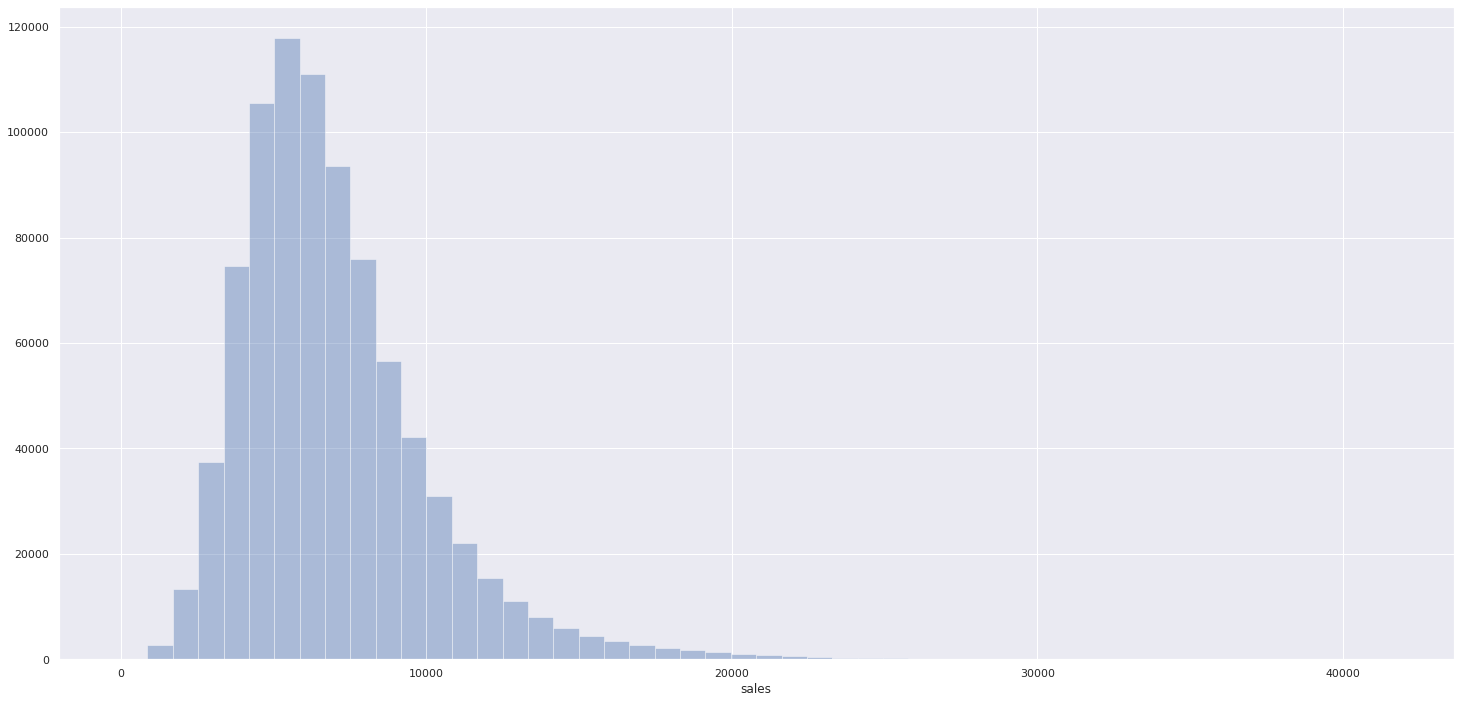

In [30]:
sns.distplot(df4['sales'], kde=False)

### 4.1.2 Numerical Variable

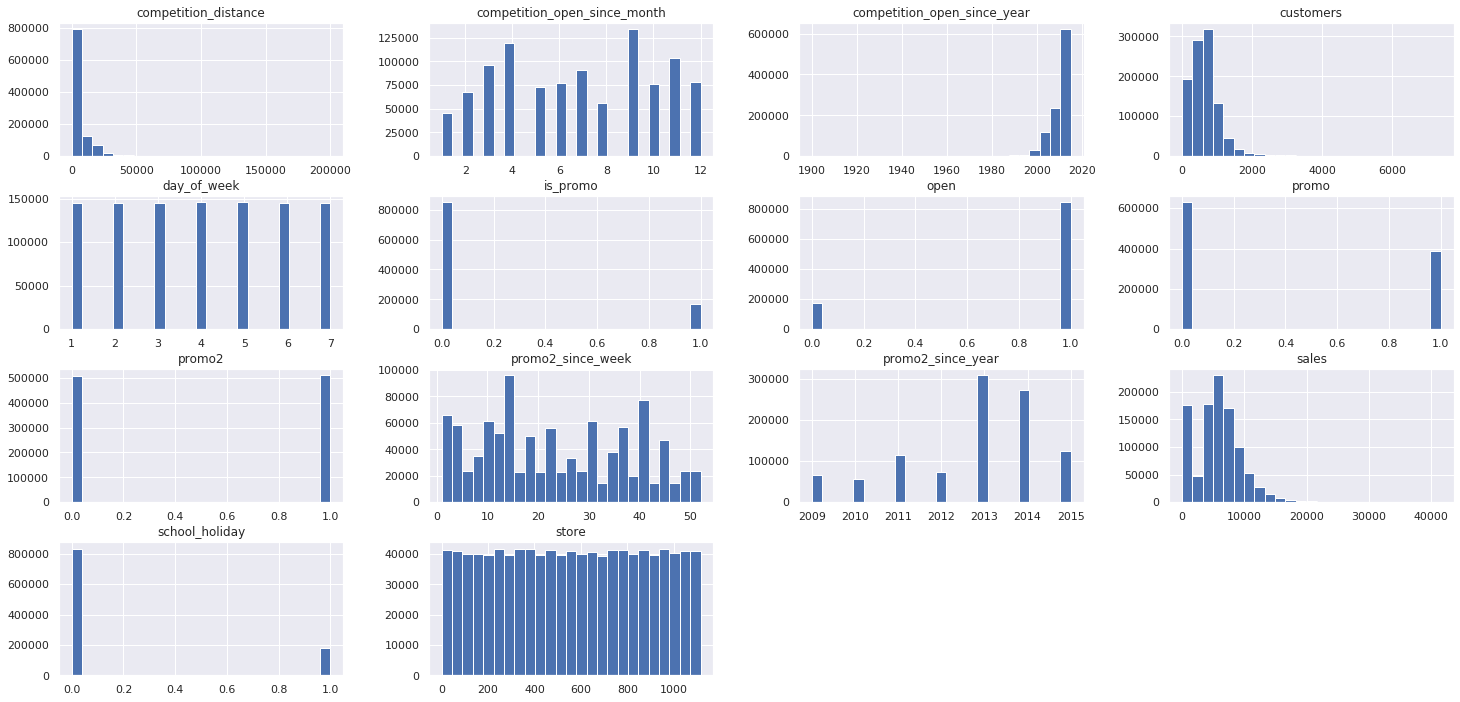

In [31]:
num_attributes.hist( bins=25);

### 4.1.3 Categorical Variable

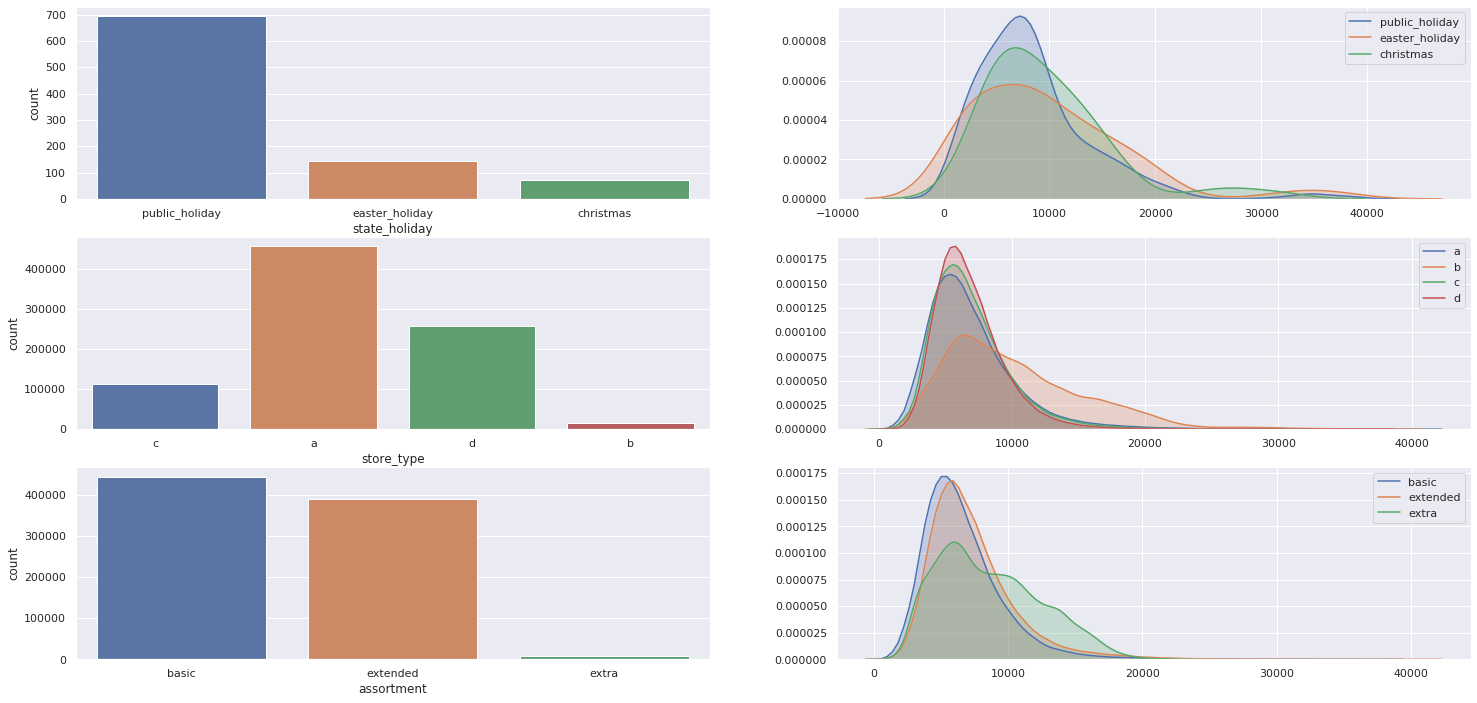

In [32]:
# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

# store_type
plt.subplot(3, 2, 3)
sns.countplot(df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

# assortment
plt.subplot(3, 2, 5)
sns.countplot(df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True);

## 4.2 Bivariate Analysis

### **H1 -** Lojas com maior sortimento deveriam vender mais.

**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.

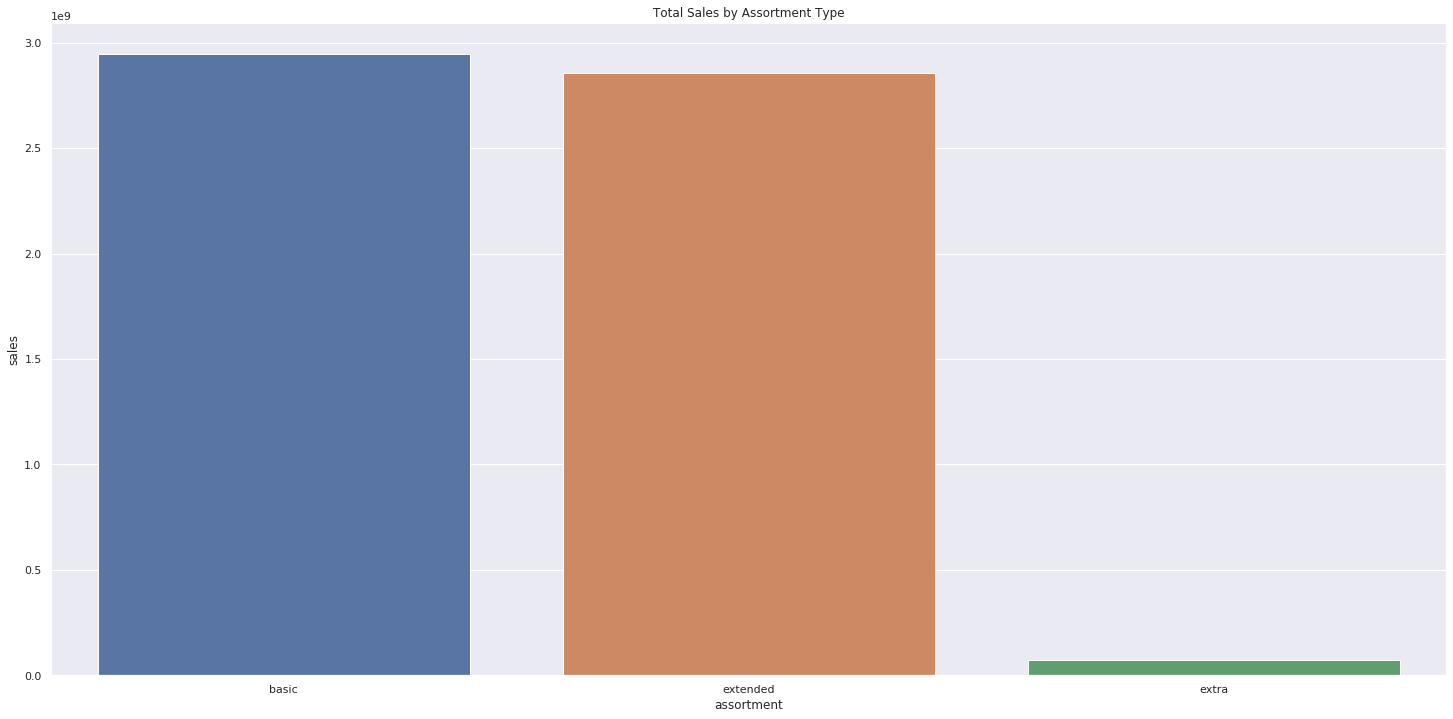

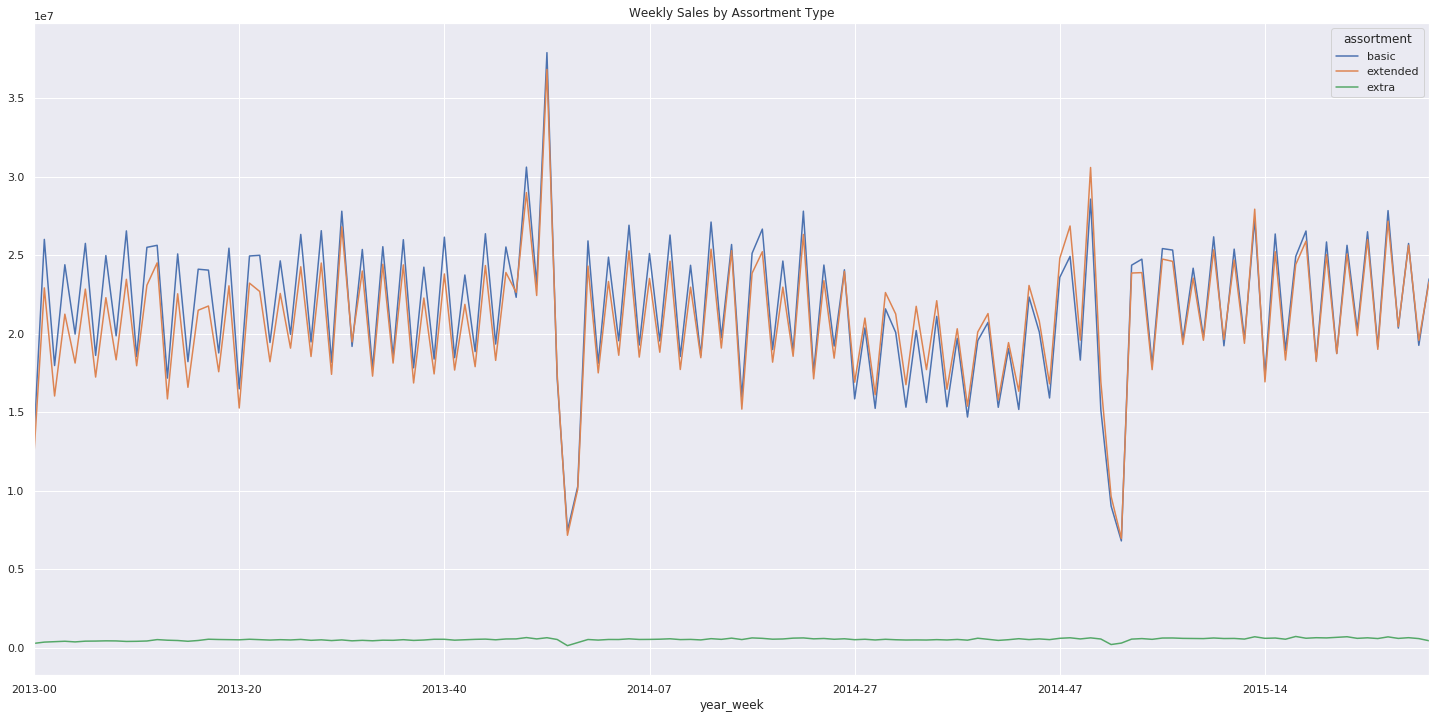

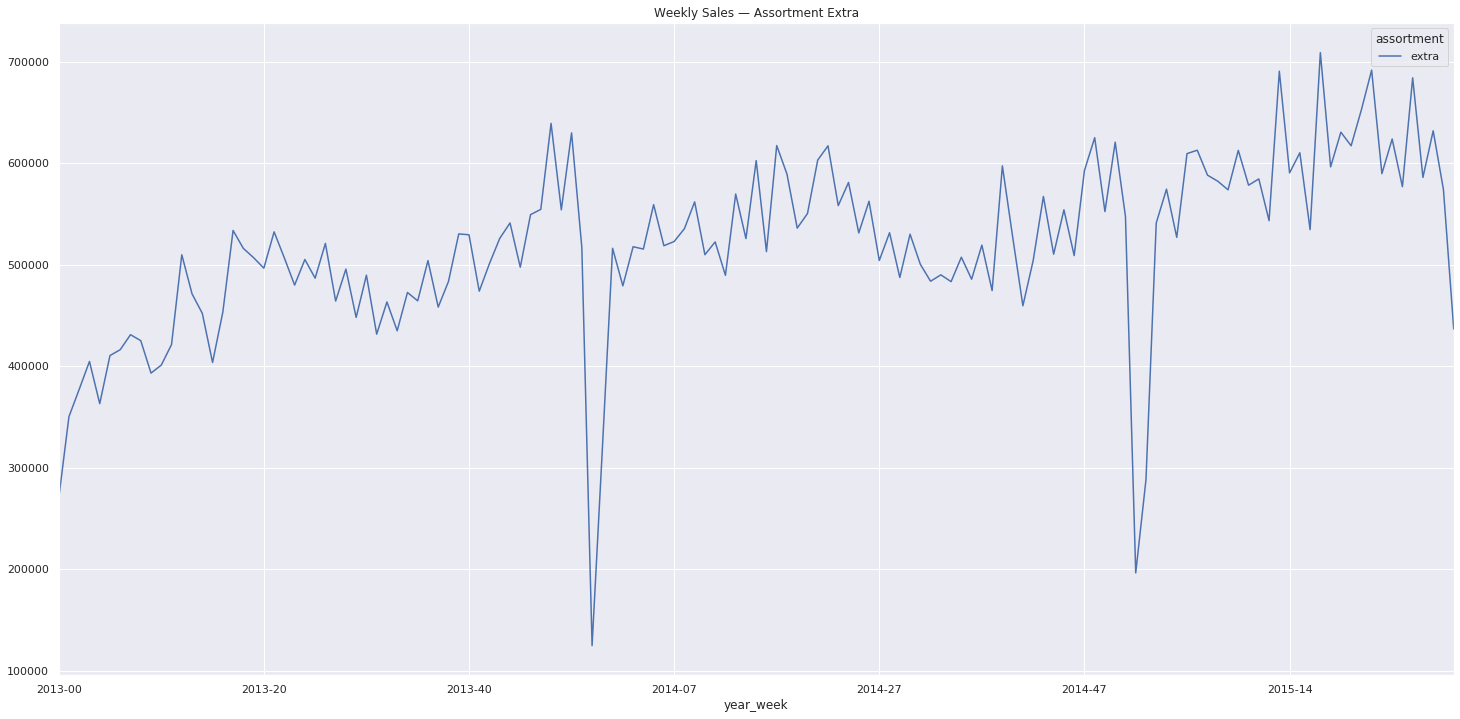

In [33]:
# --- Graph 1
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1)
plt.title("Total Sales by Assortment Type")

# --- Graph 2
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales').plot()
plt.title("Weekly Sales by Assortment Type")

# --- Graph 3
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales').plot()
plt.title("Weekly Sales — Assortment Extra");

### **H2 -** Lojas com competidores mais proximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS.

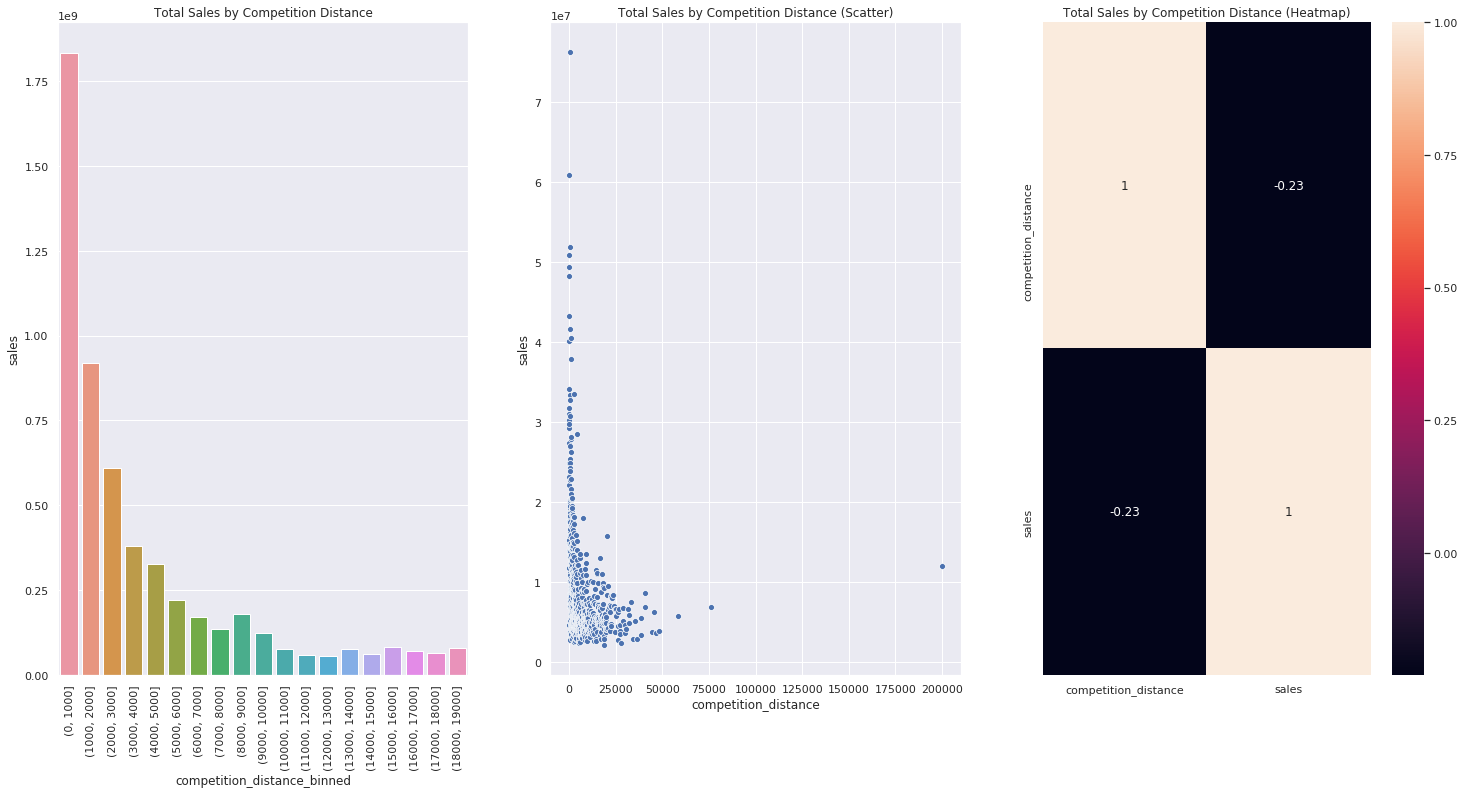

In [34]:
# -- Graph 1
plt.subplot(1,3,1)
aux1 = df4[['competition_distance', 'sales']].groupby(['competition_distance']).sum().reset_index()
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby(['competition_distance_binned']).sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.title("Total Sales by Competition Distance")
plt.xticks(rotation=90)

# -- Graph 2
plt.subplot(1,3,2)
aux1 = df4[['competition_distance', 'sales']].groupby(['competition_distance']).sum().reset_index()
sns.scatterplot(x='competition_distance', y='sales', data=aux1)
plt.title("Total Sales by Competition Distance (Scatter)")

# -- Graph 3
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.title("Total Sales by Competition Distance (Heatmap)");


### **H3 -** Lojas com competidores a mais tempo deveriam vender mais.
**FALSA** Lojas com COMPETIDORES HA MAIS TEMPO vendem MENOS.

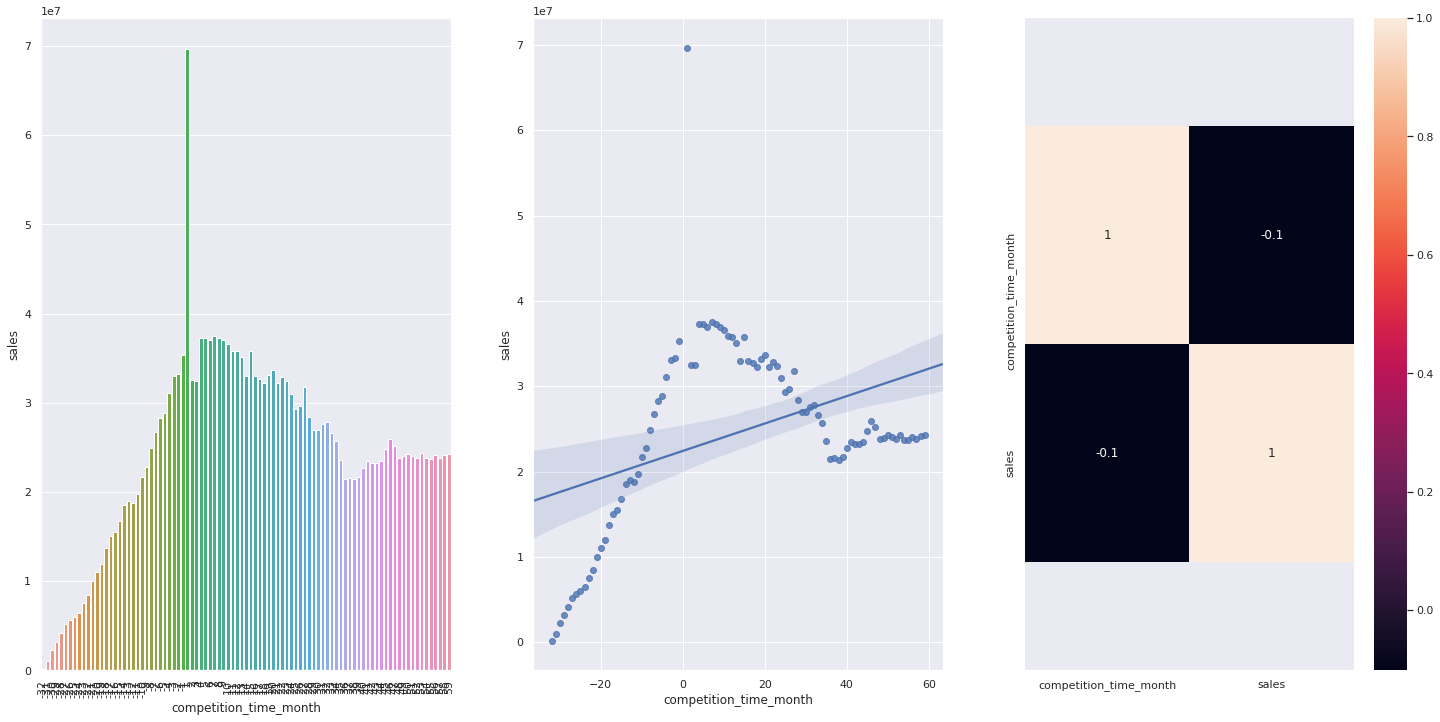

In [35]:
# -- Graph 1
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby(['competition_time_month']).sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 60) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation = 90)

# -- Graph 2
plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

# -- Graph 3
plt.subplot(1,3,3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True)
bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5);

### **H4 -** Lojas com promocoes ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promocoes ativas POR MAIS TEMPO vendem MENOS, depois de um periodo de promocao.

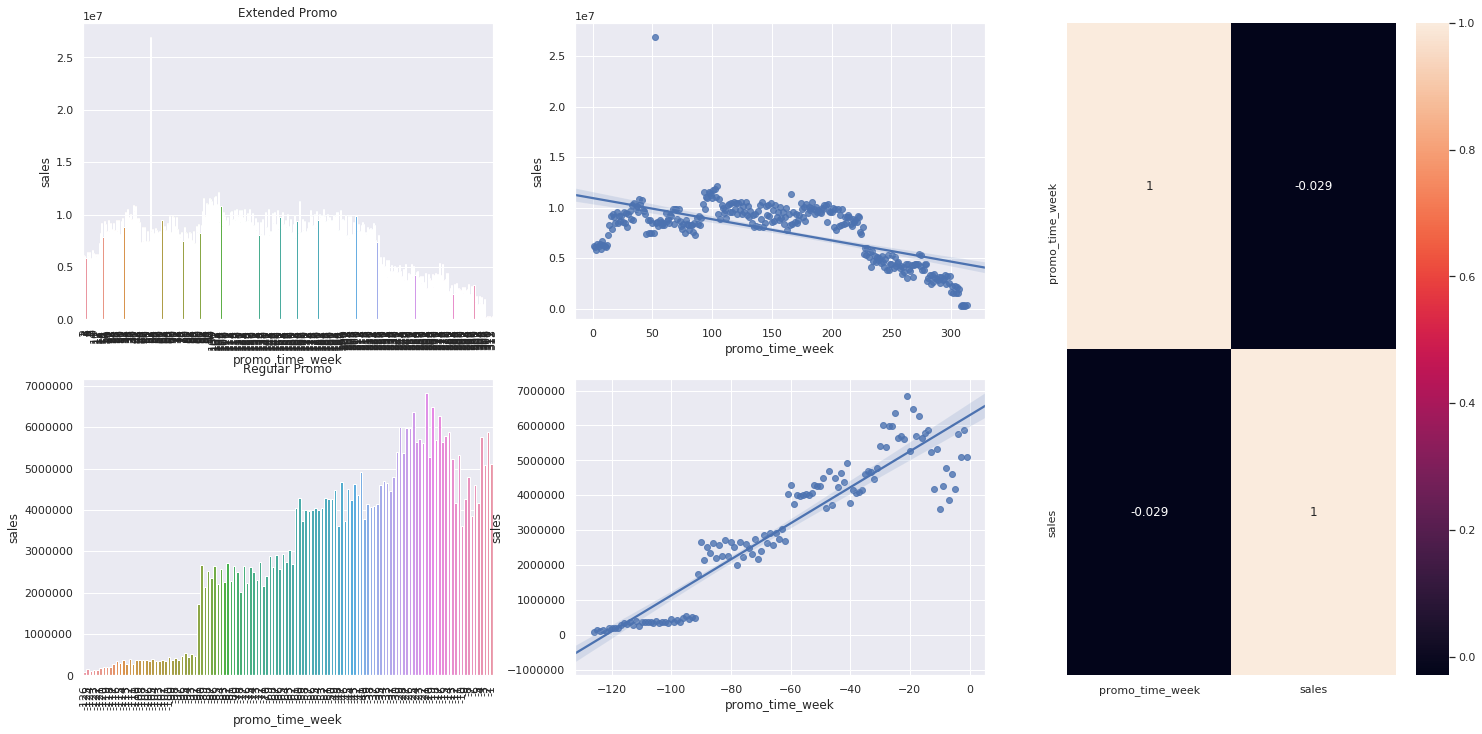

In [36]:
aux1 = df4[['promo_time_week', 'sales']].groupby(['promo_time_week']).sum().reset_index()

grid = GridSpec(2,3)

# -- Graph 1 - Extended Promo
plt.subplot( grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0 ] # extended
plt.title('Extended Promo')
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks( rotation=90)

# -- Graph 2 - Tendency Extended Promo
plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

# -- Graph 3 - Regular Promo
plt.subplot( grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0 ] # regular
plt.title('Regular Promo')
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks( rotation=90)

# -- Graph 3 - Tendency Regular Promo
plt.subplot( grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

# -- Graph 4 - Correlation
plt.subplot( grid[:,2])
sns.heatmap( aux1.corr(method='pearson'), annot=True);



### <s>**H5 -** Lojas com mais dias de promocao deveriam vender mais.</s>

### **H6 -** Lojas com mais promocoes consecutivas deveriam vender mais.
**FALSA** Lojas com promocoes CONSECUTIVAS vendem MENOS

In [37]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().sort_values(by=['sales'], ascending=True)

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


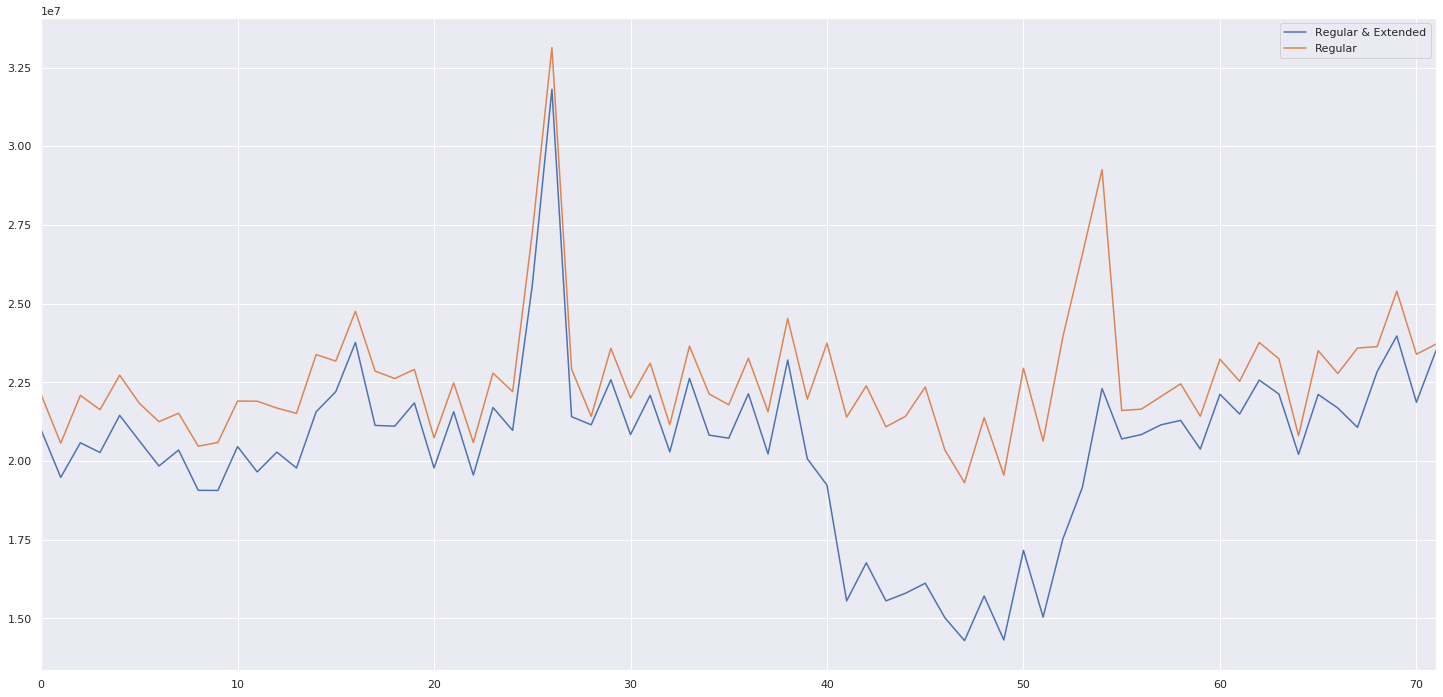

In [38]:
# -- Graph 1 - Regular & Extended promo
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

# -- Graph 2 - Regular promo
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Regular & Extended', 'Regular'])

### **H7 -** Lojas abertas durante o feriado de natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado de natal vendem MENOS

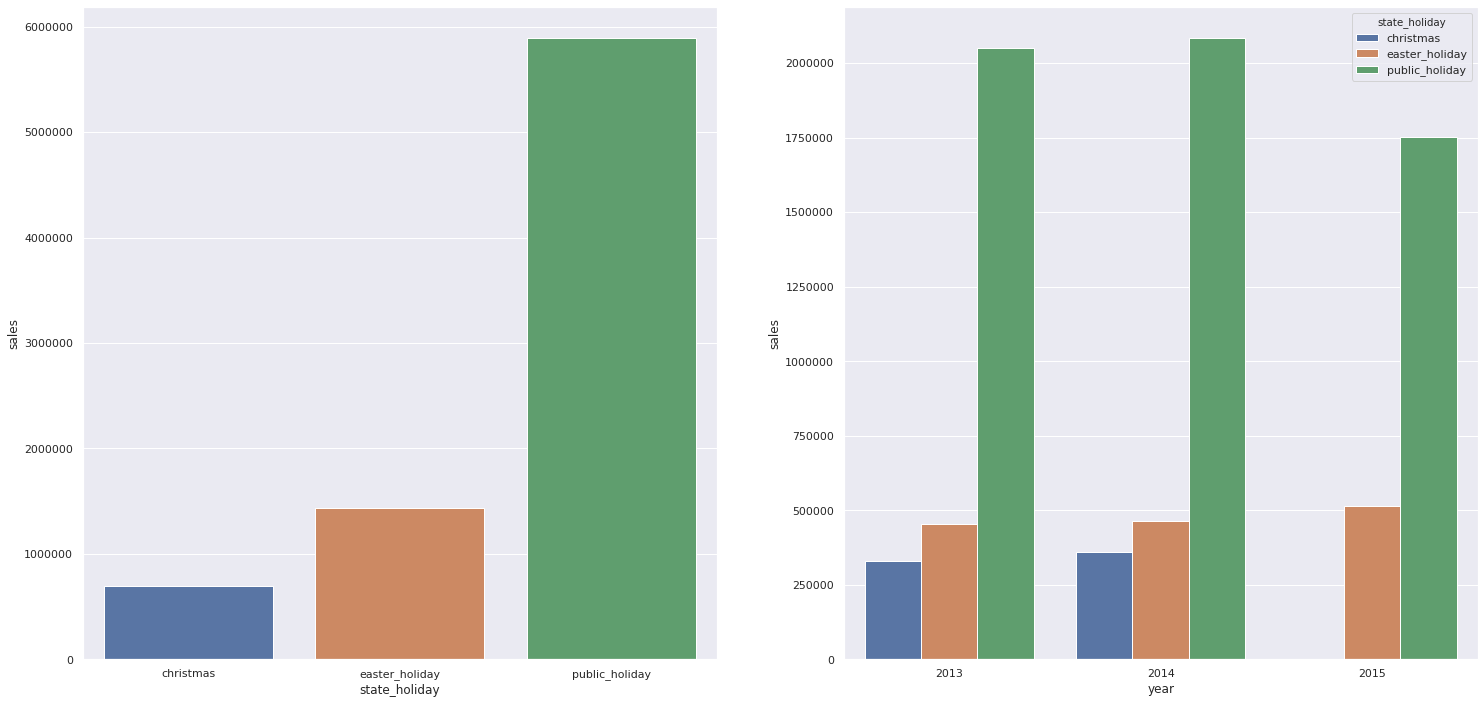

In [39]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot( x = 'state_holiday', y='sales', data=aux1)

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### **H8 -** Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem MENOS ao longo dos anos

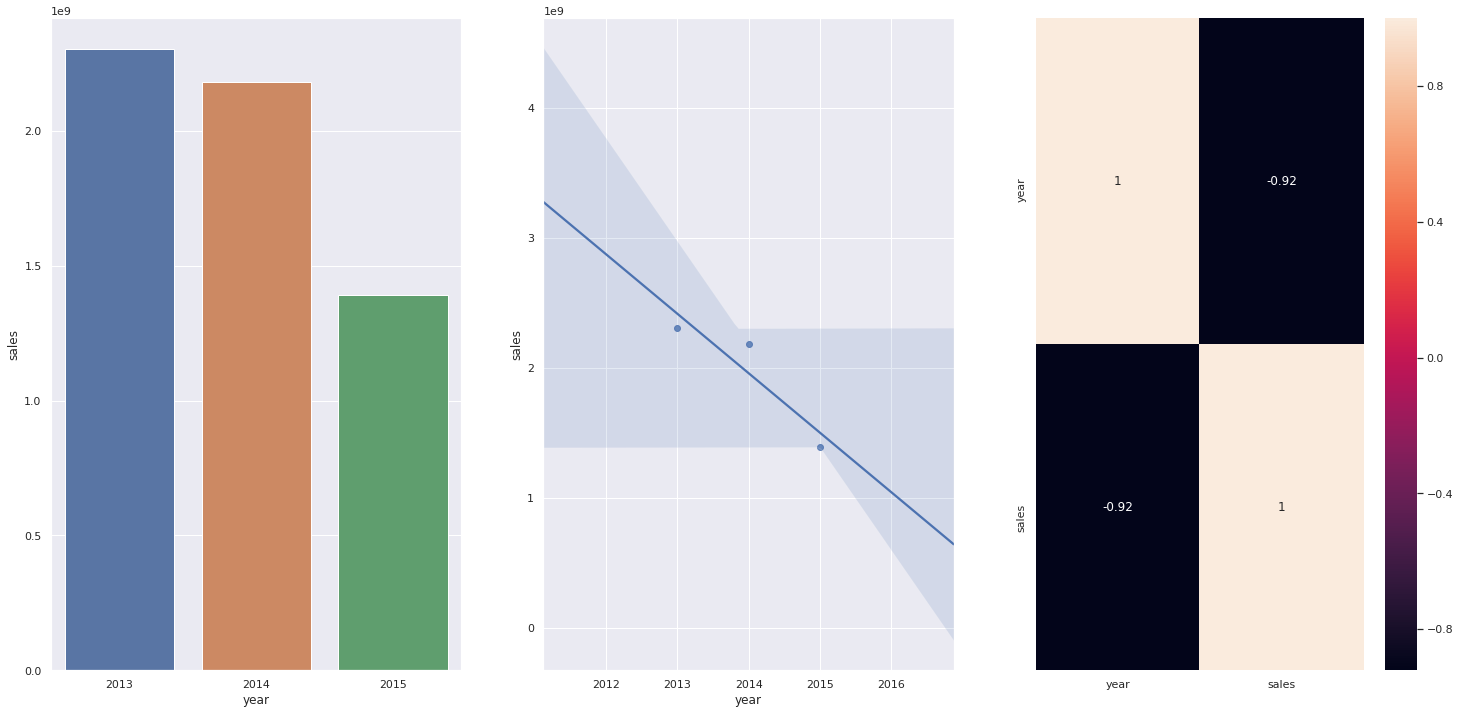

In [40]:
aux = df4[['year', 'sales']].groupby(['year']).sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux)

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux)

plt.subplot(1,3,3)
sns.heatmap(aux.corr(method='pearson'), annot=True);

### **H9 -** Lojas deveriam vender mais no segundo semestre do ano
**FALSA** Lojas vendem MENOS no segundo semestre do ano

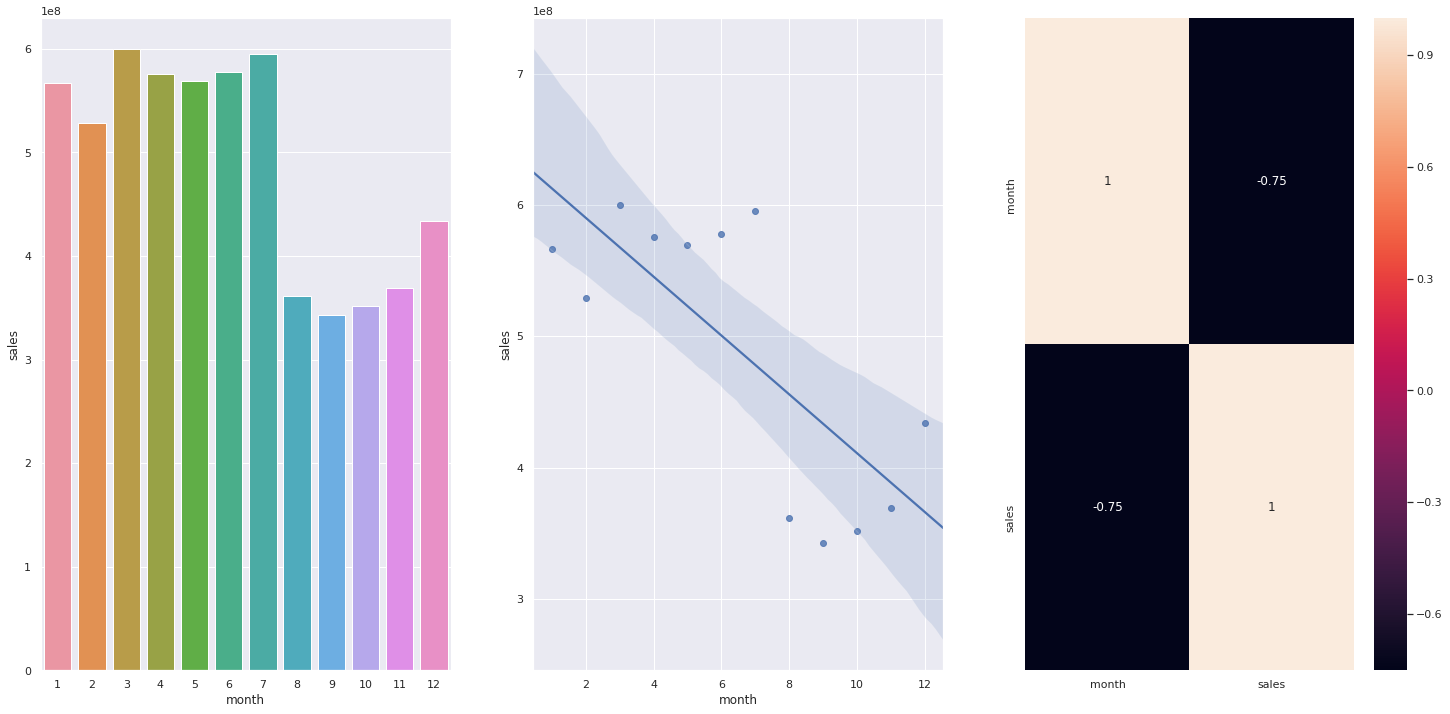

In [41]:
aux = df4[['month', 'sales']].groupby(['month']).sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux)

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux)

plt.subplot(1,3,3)
sns.heatmap(aux.corr(method='pearson'), annot=True);

### **H10 -** Lojas deveriam vender mais depois do dia 10 de cada mes
**VERDADEIRA** Lojas vendem MAIS depois do dia 10

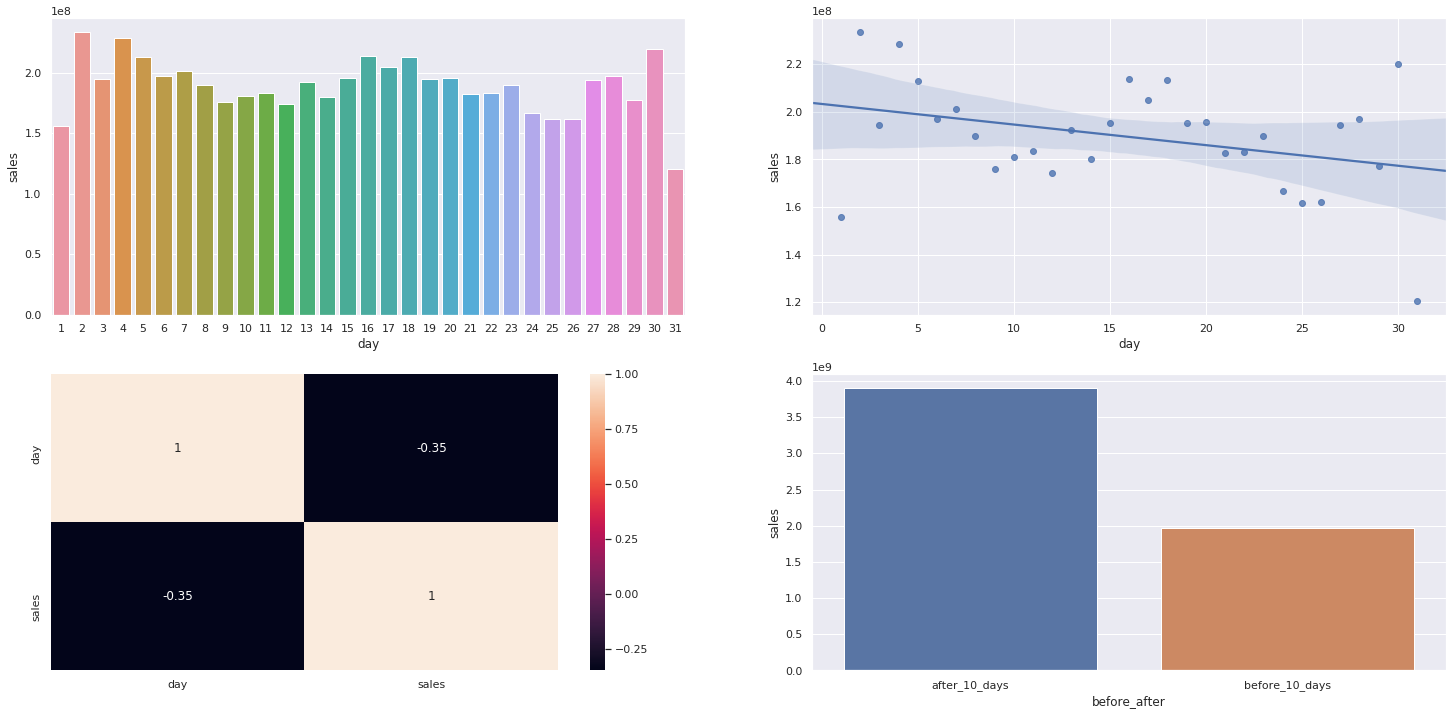

In [42]:
aux = df4[['day', 'sales']].groupby(['day']).sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux)

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux)

plt.subplot(2,2,3)
sns.heatmap(aux.corr(method='pearson'), annot=True)


aux['before_after'] = aux['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux1 = aux[['before_after', 'sales']].groupby(['before_after']).sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x ='before_after', y='sales', data=aux1);

### **H11 -** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem MENOS aos finais de semana

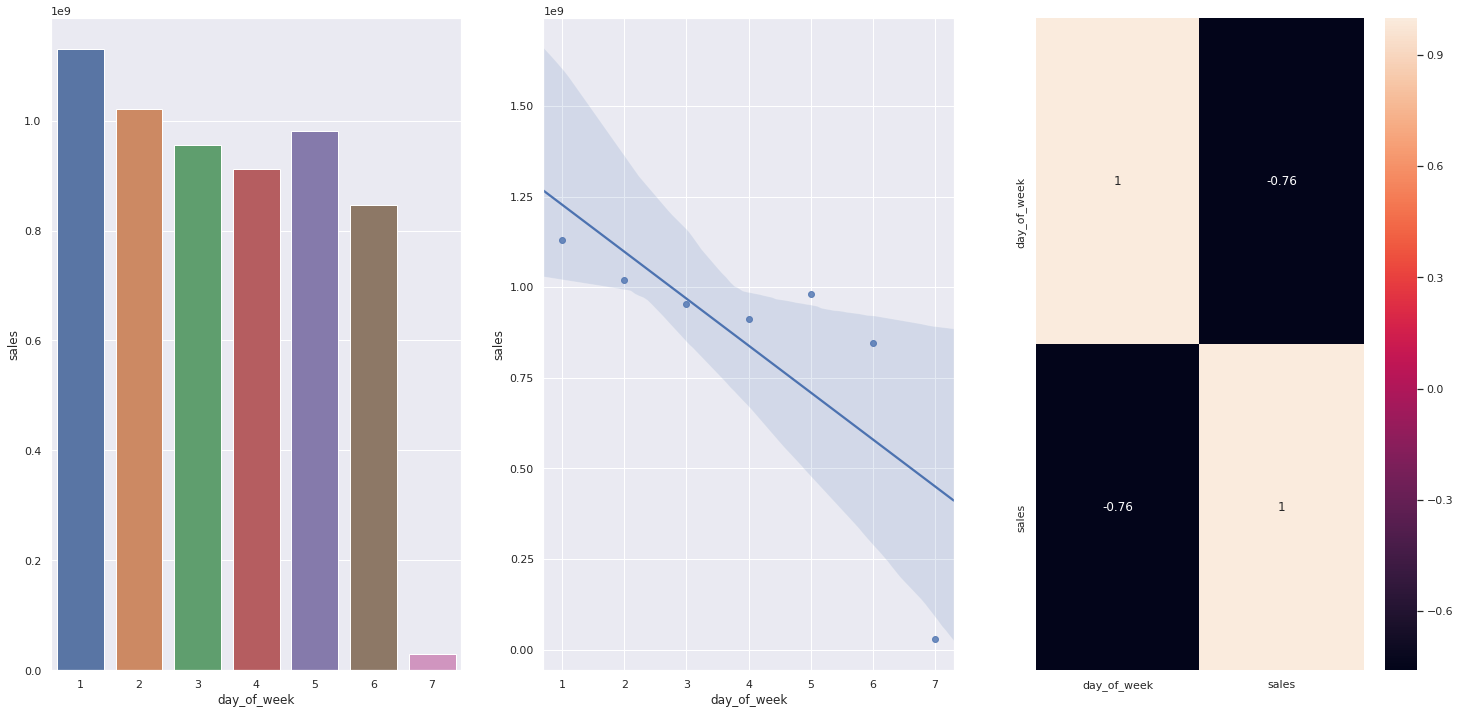

In [43]:
aux = df4[['day_of_week', 'sales']].groupby(['day_of_week']).sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux)

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux)

plt.subplot(1,3,3)
sns.heatmap(aux.corr(method='pearson'), annot=True);

### **H12 -** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas vendem MENOS durante os feriados escolares, exceto Julho e Agosto.

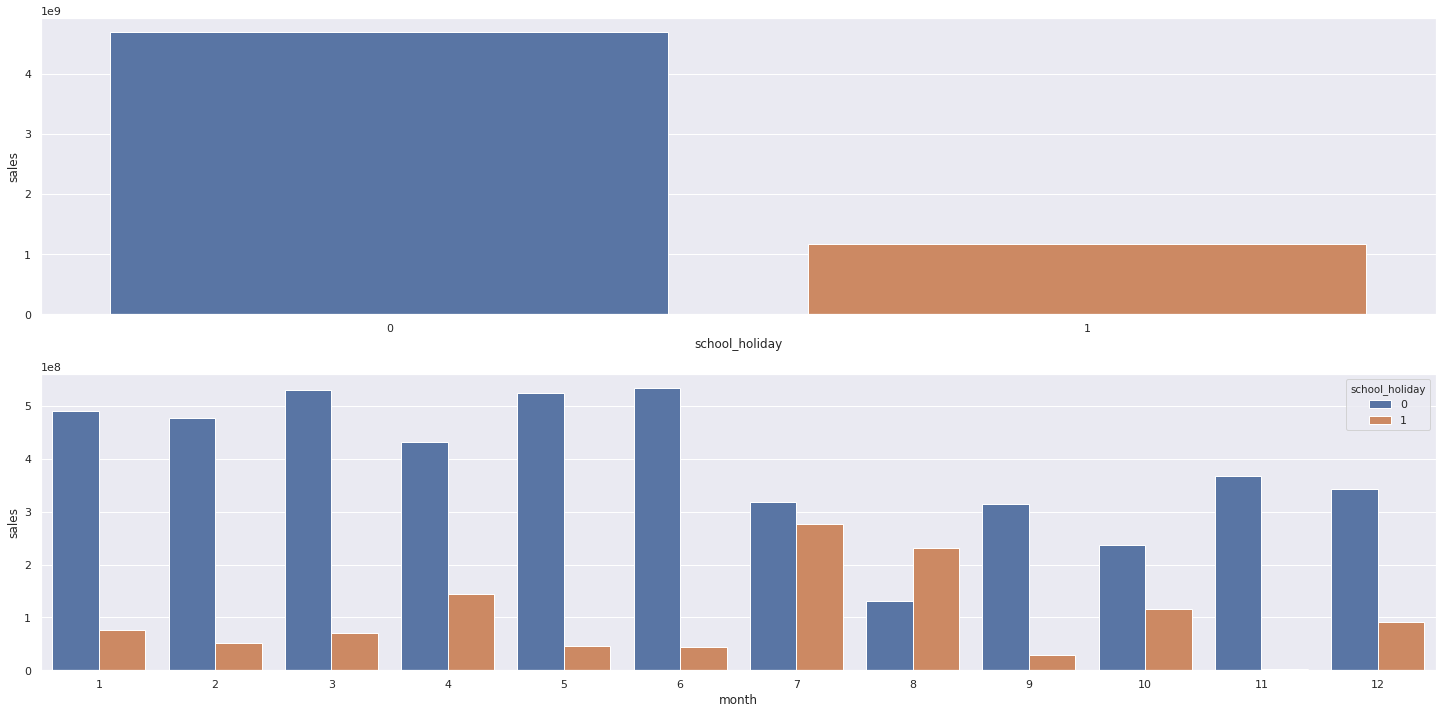

In [44]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1)

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()

plt.subplot(2,1,2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

### Resume Analysis

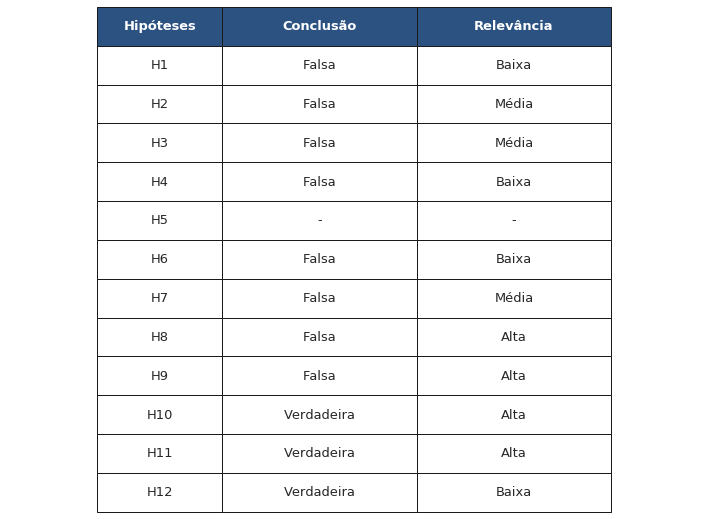

In [45]:
resumo_bivariada = pd.DataFrame({
    'Hipóteses': ['H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12'],
    'Conclusão': ['Falsa', 'Falsa', 'Falsa', 'Falsa', '-', 'Falsa', 'Falsa', 'Falsa', 'Falsa', 'Verdadeira', 'Verdadeira', 'Verdadeira'],
    'Relevância': ['Baixa', 'Média', 'Média', 'Baixa', '-', 'Baixa', 'Média', 'Alta', 'Alta', 'Alta', 'Alta', 'Baixa']
})

plt.figure(figsize=(10, 6))
plt.axis('off')

table = plt.table(cellText=resumo_bivariada.values,
                  colLabels=resumo_bivariada.columns,
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.18, 0.28, 0.28])

table.auto_set_font_size(False)
table.set_fontsize(13)
table.scale(1, 2.6)

# Cabeçalho
for i in range(3):
    table[(0, i)].set_facecolor('#2c5282')
    table[(0, i)].set_text_props(weight='bold', color='white')

plt.tight_layout()
plt.show()

## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

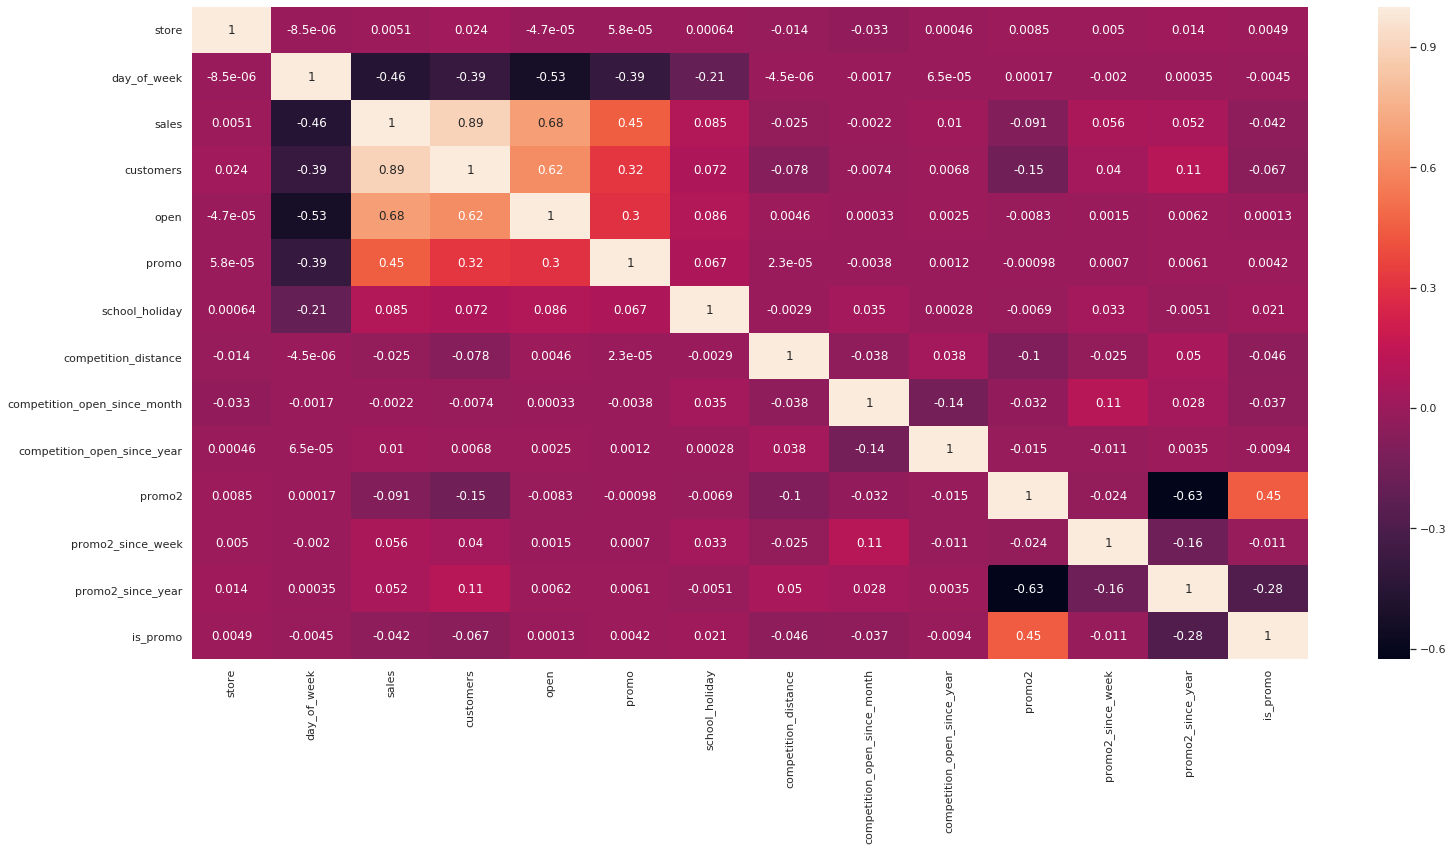

In [46]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical Attributes

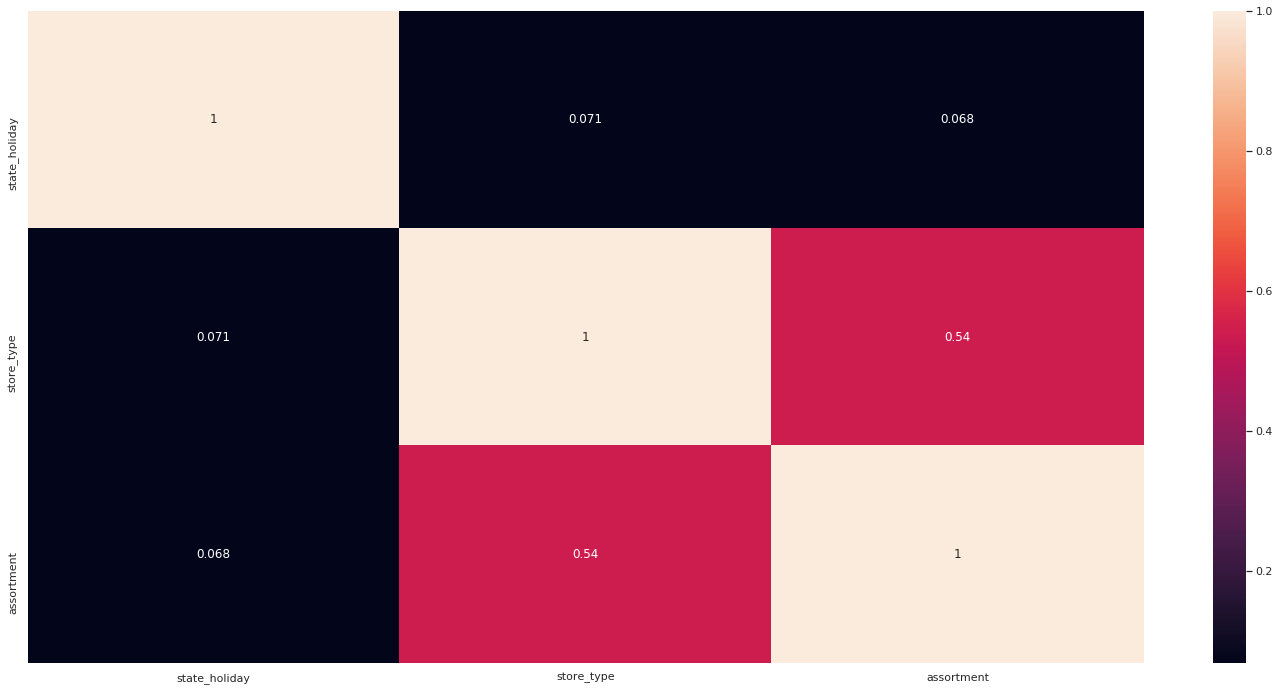

In [47]:
a = df4.select_dtypes( include='object')

# cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
'store_type': [a4, a5, a6],
'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )

# 5.0 DATA PREPARATION

In [48]:
df5 = df4.copy()

## 5.1 Normalization

## 5.2 Rescaling

In [49]:
a = df5.select_dtypes(include=['int64','float64'])

In [50]:
rs = RobustScaler()
mms = MinMaxScaler()


# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition time month

df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)


## 5.3 Transform

### 5.3.1 Encoding

In [51]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

#store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

#assortment - Ordinal Encoding
assortment_dict = {'basic': 1,
                   'extra': 2,
                   'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

In [52]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 Nature Transformation

In [53]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * ( 2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * ( 2. * np.pi/7)))

#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * ( 2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * ( 2. * np.pi/12)))

#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * ( 2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * ( 2. * np.pi/30)))

#week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * ( 2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * ( 2. * np.pi/52)))

# 6.0 FEATURE SELECTION

In [54]:
df6 = df5.copy()

In [55]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

## 6.1 Split traintest

In [56]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [57]:
# Train dataset

X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

## 6.2 Boruta as Feature Selector

In [58]:
# Dataset for Boruta
X_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()

In [59]:
# RandomForest
#rf = RandomForestRegressor(n_jobs=-1)

# Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 6.2.1 Best Features - Boruta

In [60]:
#cols_selected = boruta.support_.tolist()

# best features
#X_train_fs = X_train.drop(['date', 'sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

## 6.3 Manual Feature Selection

In [61]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add

feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0 MACHINE LEARNING MODEL

In [62]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation (variaveis relevantes + vendas e data)
x_training = X_train[cols_selected_boruta_full]

## 7.1 Average Model

In [70]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [106]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression - Cross Validation

In [127]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=True)
lr_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear Regression Regularized Model - Lasso

In [109]:
# model
lrr = Lasso( alpha = 0.01 ).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 - Linear Rergression Lasso - Cross Validation

In [128]:
lrr_result_cv = cross_validation(x_training, 5, 'Linear Regression Lasso', lrr, verbose=True)
lrr_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Random Forest Regressor

In [111]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.296634,0.099816,1008.24895


### 7.4.1 Random Forest - Cross Validation

In [129]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,838.18 +/- 218.74,0.12 +/- 0.02,1256.87 +/- 319.67


## 7.5 XGBoost

In [115]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,890.527565,0.129193,1306.496922


### 7.5.1 XGBoost - Cross Validation

In [130]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost,1048.45 +/- 172.04,0.14 +/- 0.02,1513.27 +/- 234.33


## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [116]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.296634,0.099816,1008.248950
0,XGBoost Regressor,890.527565,0.129193,1306.496922
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.6.2 Real Performance - Cross Validation

In [132]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,838.18 +/- 218.74,0.12 +/- 0.02,1256.87 +/- 319.67
0,XGBoost,1048.45 +/- 172.04,0.14 +/- 0.02,1513.27 +/- 234.33
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Linear Regression Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


# 8.0 FINE TUNING

## 8.1 Random Search

In [ ]:
# import random
# import pandas as pd
# import xgboost as xgb

# param = {
#     'n_estimators': [1500, 1700, 2500, 3000, 3500],
#     'eta': [0.01, 0.03],
#     'max_depth': [3, 5, 9],
#     'subsample': [0.1, 0.5, 0.7],
#     'colsample_bytree': [0.3, 0.7, 0.9],
#     'min_child_weight': [3, 8, 15]}

# max_eval = 5

# final_result = pd.DataFrame()

# for i in range(max_eval):

#     hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#     print(f"\nIteração {i+1}/{max_eval} → {hp}")

#     model_xgb = xgb.XGBRegressor(
#         objective='reg:squarederror',
#         n_estimators=hp['n_estimators'],
#         eta=hp['eta'],
#         max_depth=hp['max_depth'],
#         subsample=hp['subsample'],
#         colsample_bytree=hp['colsample_bytree'],
#         min_child_weight=hp['min_child_weight']
#     )

#     result = cross_validation(
#         x_training,
#         5,
#         'XGBoost Regressor',
#         model_xgb,
#         verbose=True
#     )

#     final_result = pd.concat([final_result, result])
    
# final_result

## 8.2 Final Model

In [65]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3
    }


# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'],
                                    eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    colsample_bytee=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'],
                                    n_jobs=-1).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb_tuned))
xgb_result_tuned


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,664.974997,0.097529,957.774225


In [67]:
with open('modelo_xgb_tuned_final.pkl', 'wb') as file:
    pickle.dump({
        'modelo': model_xgb_tuned,           
        'yhat': yhat_xgb_tuned,               
        'metricas': xgb_result_tuned,         
        'parametros': param_tuned,            
        'features_usadas': list(x_train.columns)  
    }, file)

print("Modelo salvo com sucesso como 'modelo_xgb_tuned_final.pkl'")

Modelo salvo com sucesso como 'modelo_xgb_tuned_final.pkl'


In [69]:
pe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
pe

-0.003545334041888066

# 9.0 Translating and Interpreting ML Error Metrics

In [68]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 Business Performance

In [69]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE

df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE','MAPE']]

In [70]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,104033.085938,100714.981535,107351.190340,3318.104402,0.565828
908,909,238233.875000,230573.337254,245894.412746,7660.537746,0.520433
875,876,203030.156250,199110.952414,206949.360086,3919.203836,0.305099
721,722,353005.781250,351013.625119,354997.937381,1992.156131,0.268338
594,595,400883.625000,397415.263170,404351.986830,3468.361830,0.242192


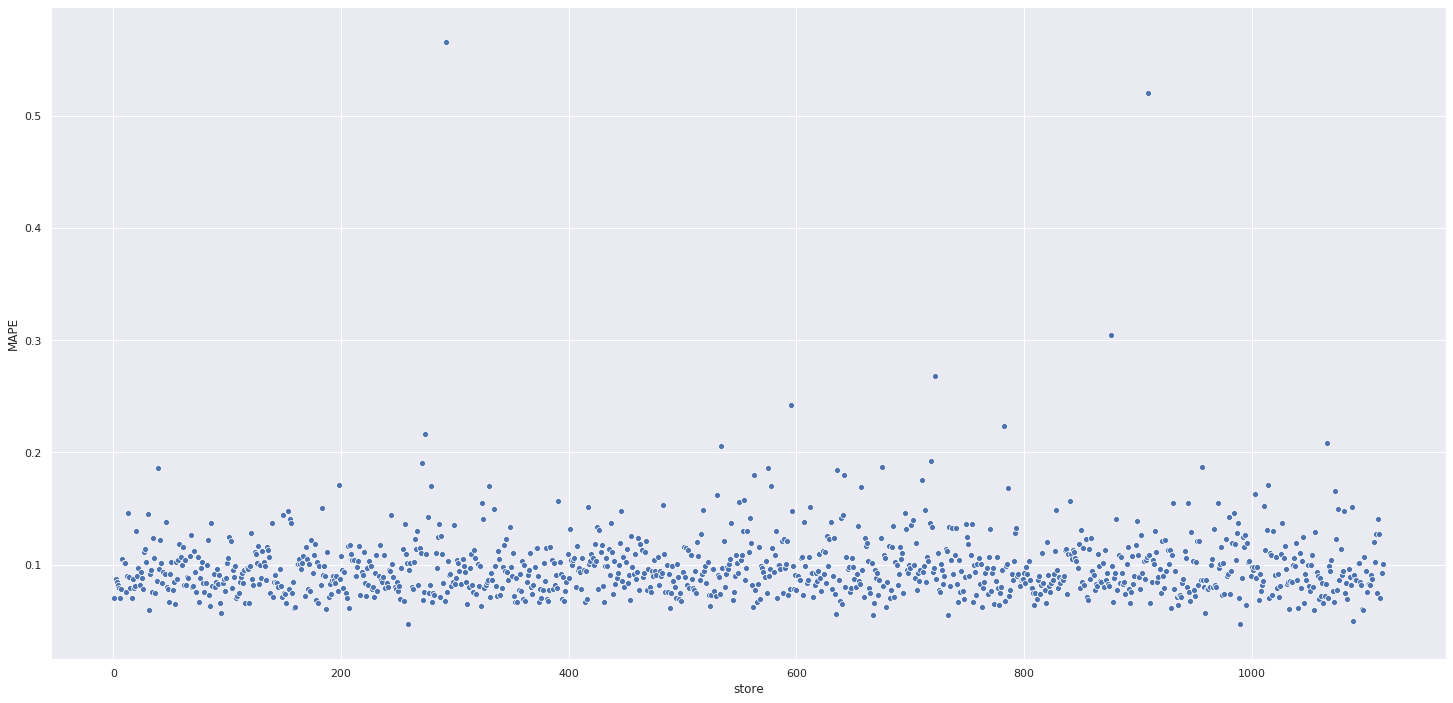

In [72]:
sns.scatterplot( x='store', y='MAPE', data=df92 );

## 9.2 Total Performance

In [73]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93


,Scenario,Values
0,predictions,"R$285,860,497.84"
1,worst_scenario,"R$285,115,015.78"
2,best_scenario,"R$286,605,979.91"


## 9.3 Machine Learning Performance

In [74]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

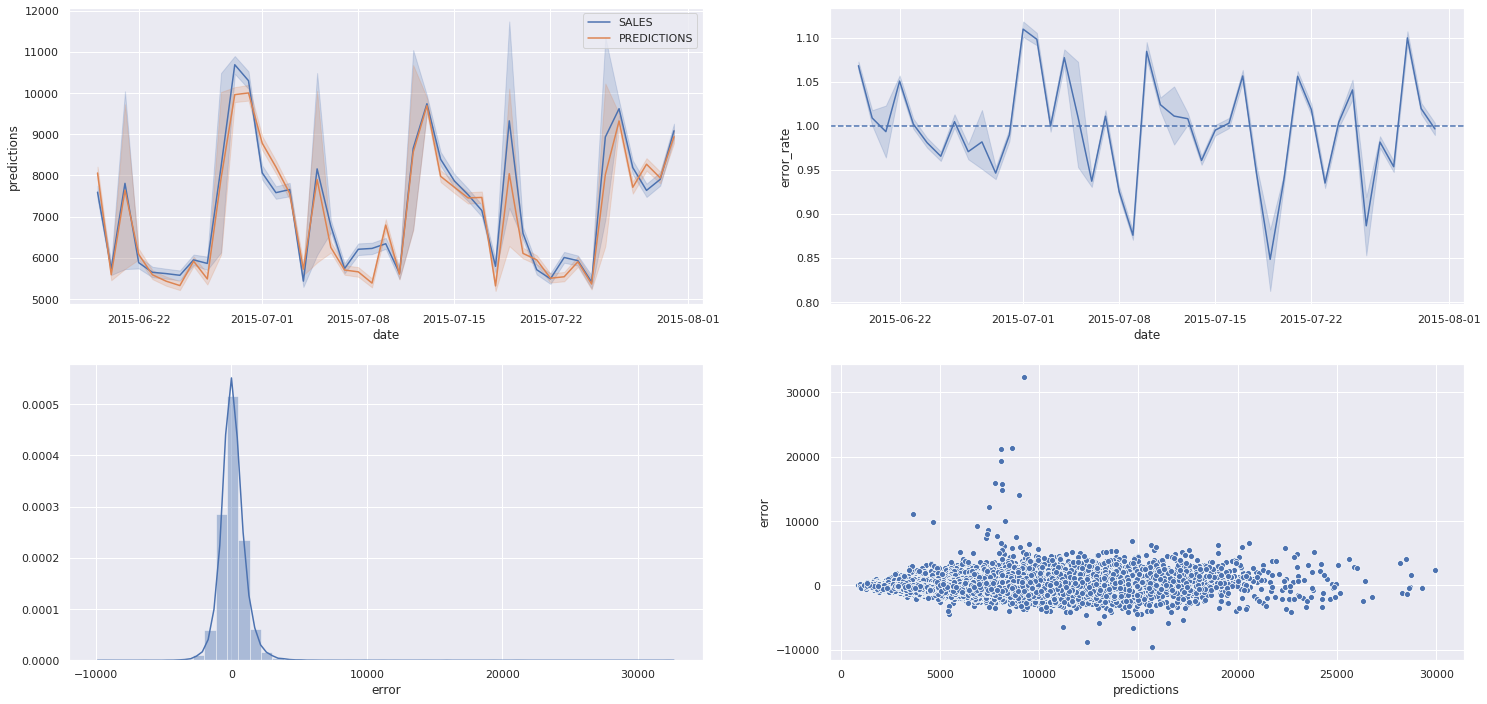

In [75]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] );
